In [1]:
# !pip install pyyaml==5.1
# !pip install "git+https://github.com/facebookresearch/detectron2.git"

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.10 ; cuda:  1.10.1
detectron2: 0.6


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


Import Detectron

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances

train_data_path = r"""."""
train_json_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\notebooks\labelme2coco_test_output\train.json"""

val_data_path = r"""."""
val_json_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\notebooks\labelme2coco_test_output\val.json"""
register_coco_instances("deepfashion_train", {}, train_json_path, train_data_path)
register_coco_instances("deepfashion_val", {}, val_json_path, val_data_path)

## Detectron config

In [5]:
output_dir = "./detectron_run1_output/"
def gen_cfg():
    cfg = get_cfg()

    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )
    )
    cfg.DATASETS.TRAIN = ("deepfashion_val",)
    cfg.DATASETS.TEST = ()
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )  # Let training initialize from model zoo

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.001
    cfg.SOLVER.WARMUP_ITERS = 1000
    cfg.SOLVER.MAX_ITER = 3000
    cfg.SOLVER.STEPS = (1000, 1500)
    cfg.SOLVER.GAMMA = 0.05
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

    cfg.TEST.EVAL_PERIOD = 500
    cfg.OUTPUT_DIR = output_dir
    # cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
        0.55  # set the testing threshold for this model
    )
    cfg.DATASETS.TEST = ("deepfashion_val",)
    return cfg
    
cfg = gen_cfg()

In [6]:
import torch
print(torch.version)
print(torch.cuda.is_available())

<module 'torch.version' from 'c:\\Users\\dummy\\Anaconda3\\envs\\cv-general\\lib\\site-packages\\torch\\version.py'>
True


In [7]:
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/07 21:40:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (13, 256, 1, 

[09/07 21:40:01 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\dummy\Anaconda3\envs\cv-general\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/07 21:40:17 d2.utils.events]:  eta: 0:18:56  iter: 19  total_loss: 11.03  loss_cls: 2.667  loss_box_reg: 0.1169  loss_mask: 0.6927  loss_rpn_cls: 6.707  loss_rpn_loc: 0.8411  time: 0.3770  data_time: 0.2430  lr: 1.931e-06  max_mem: 3195M
[09/07 21:40:24 d2.utils.events]:  eta: 0:18:47  iter: 39  total_loss: 9.373  loss_cls: 2.506  loss_box_reg: 0.04065  loss_mask: 0.6921  loss_rpn_cls: 5.526  loss_rpn_loc: 0.6144  time: 0.3757  data_time: 0.0026  lr: 2.911e-06  max_mem: 3195M
[09/07 21:40:32 d2.utils.events]:  eta: 0:18:34  iter: 59  total_loss: 7.281  loss_cls: 2.33  loss_box_reg: 0.004093  loss_mask: 0.6913  loss_rpn_cls: 3.818  loss_rpn_loc: 0.4269  time: 0.3727  data_time: 0.0026  lr: 3.891e-06  max_mem: 3195M
[09/07 21:40:39 d2.utils.events]:  eta: 0:18:29  iter: 79  total_loss: 5.392  loss_cls: 2.192  loss_box_reg: 0.004115  loss_mask: 0.6904  loss_rpn_cls: 2.093  loss_rpn_loc: 0.365  time: 0.3711  data_time: 0.0028  lr: 4.871e-06  max_mem: 3195M
[09/07 21:40:46 d2.utils.even

In [8]:
! tensorboard --logdir detectron_run0_output

^C


In [9]:
cfg = gen_cfg()
cfg.OUTPUT_DIR = output_dir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepfashion_val", )
predictor = DefaultPredictor(cfg)

[09/07 22:00:06 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
import live_cell_tracker.livecell_segment.datasets

# dir_path = Path('D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched')
dir_path = Path('D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched')
imgs = live_cell_tracker.livecell_segment.datasets.LiveCellImageDataset(dir_path, ext="tif")

120 tif img file paths loaded: 


In [16]:
raw_img1 = imgs[50][:, :, np.newaxis]
# raw_img1 = normalize_img_by_zscore(raw_img1)

In [17]:
def detectron_predict_single_img(img):
    outputs = predictor(img)
    return outputs

def detectron_visualize_img(img):
    outputs = detectron_predict_single_img(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    figure = plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(v.get_image()[:, :, ::-1])

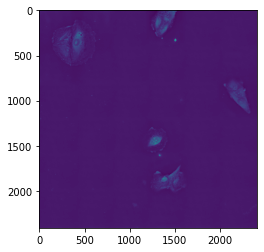

In [18]:
plt.imshow(raw_img1)

In [19]:
detectron_predict_single_img(raw_img1)

{'instances': Instances(num_instances=26, image_height=2408, image_width=2408, fields=[pred_boxes: Boxes(tensor([[2064.5090,  129.9195, 2370.5298,  461.9599],
         [1630.5415,   19.8855, 2202.1636,  356.9460],
         [1899.6815,  136.2050, 2256.4734,  525.5958],
         [ 143.5476,  102.9632,  522.3571,  490.3944],
         [1399.0018, 2050.1079, 1673.6915, 2369.9514],
         [ 869.2407, 2050.1086, 1143.9285, 2369.9531],
         [1013.7214, 2050.1079, 1288.4094, 2369.9529],
         [1158.2023, 2050.1084, 1432.8907, 2369.9524],
         [1302.6824, 2050.1077, 1577.3721, 2369.9509],
         [1495.3252, 2050.1121, 1770.0005, 2369.9509],
         [ 772.9224, 2050.1086, 1047.6091, 2369.9521],
         [1685.1005,   86.6681, 2135.8188,  490.1168],
         [ 628.4417, 2050.1091,  903.1292, 2369.9524],
         [1594.8192, 2052.1311, 1864.8279, 2371.3447],
         [  48.1620,  174.8125,  280.0980,  632.1226],
         [ 329.2274,   77.5372,  622.3424,  530.7009],
         [ 231.0

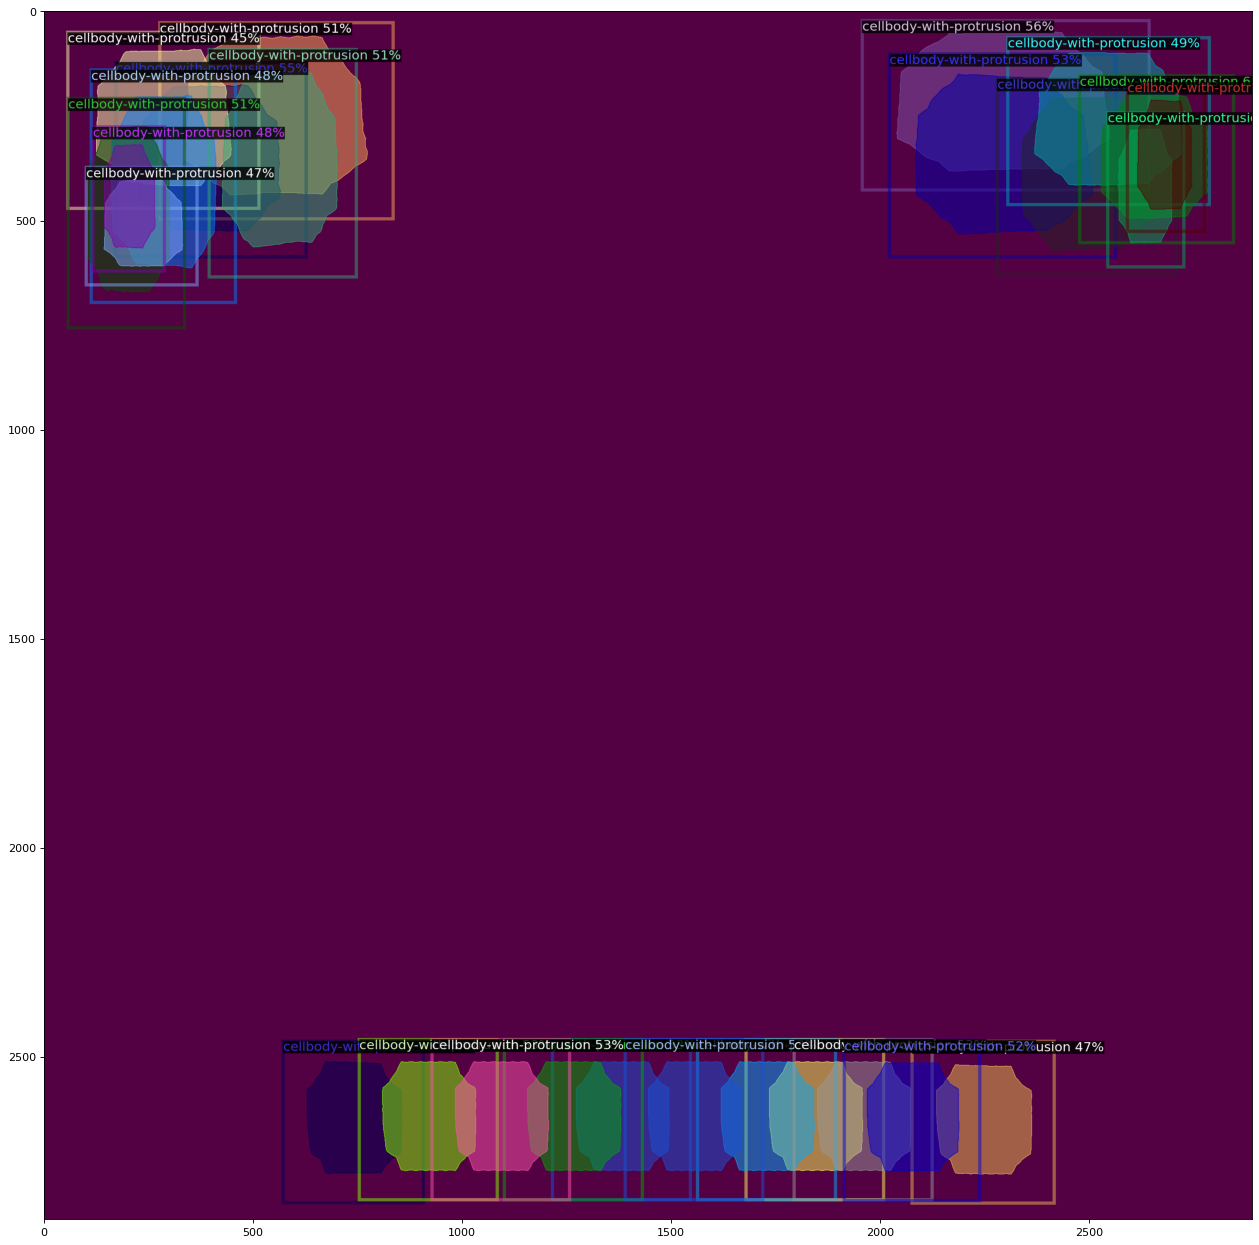

In [15]:
detectron_visualize_img(raw_img1)